# Imports

In [ ]:
import sys
 
# setting path
sys.path.append('..')

from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle
from statannotations.Annotator import Annotator
from collections import defaultdict
from scipy import stats
import mne
import glob 
import random

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
import matplotlib
matplotlib.use('Agg')

# Batch convert raw files into pickle

In [3]:
from mna.utils.rnapp_data_format import read_all_files

In [4]:
#read_all_files(data_dir='/home/jupyter/raw_data/',
#               pickle_dir='/home/jupyter/mna/data/', save_pickle=True)

# Batch analysis

In [5]:
data_dir = "../data/"
timestamp_fixer_path = f"{data_dir}annotated/fit_timestamp_adjuster.pkl"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/batch_analysis_non_baseline/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
ts_fixer = pickle.load(open(timestamp_fixer_path, 'rb')) # features == 'processed_trial_duration',  'processed_trial_duration_1', 'lsl_timestamps'
interrupted_sessions = [(13,1), (22,1)]
remove_sessions = [(13,1),(15,1),(22,1)]
reference_ica = "sbj20ssn03"
save_data_pkl = True # save data into pickle files
save_ica_plts = False # save ICA components plots
epoch_raw_eeg = False # epoching raw data
motor_events = True
preturn = 1000
rs = 64 # random seed

## Parallel batch analysis

In [6]:
# loop over the list of csv files
def read_motor_csvs():
    csv_files = glob.glob(os.path.join(output_dir, "ppid*_motor.csv"))
    all_dfs = None
    for f in csv_files:
        # read the csv file
        if not type(all_dfs)==pd.core.frame.DataFrame:
            all_dfs = pd.read_csv(f)
        else:
            all_dfs = pd.concat([all_dfs, pd.read_csv(f)], ignore_index=True)
    all_dfs = all_dfs[all_dfs.columns.drop(list(all_dfs.filter(regex='Unnamed')))]
    return all_dfs

def get_motor_epochs():
    epochs_files = glob.glob(os.path.join(output_dir, "**/*ica_epochs.pickle"), recursive=True)
    motor_epochs = []
    for each_file in epochs_files:
        motor_epochs.append(pickle.load(open(each_file, 'rb')))
    motor_epochs = mne.concatenate_epochs(motor_epochs)
    return motor_epochs

In [9]:
def process_file(ica_dict, each_file, overwrite=False):
    ica_epochs_dict = {}
    eog_idx_dict = {}
    events_dict = {}
    turns_df = None
    input_path = data_dir + each_file

    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]
    
    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    if reference_ica in ica_dict:
        ref_ica = ica_dict['sbj20ssn03']
    elif sbj+ssn == reference_ica:
        ref_ica = None
    if not overwrite and os.path.exists(f"{output_dir}/saved_files/{sbj+ssn}/"):
        print(sbj+ssn,'sbj+ssn already exists')
        return None

    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data, ts_fixer, remove_id_sessions=remove_sessions, interrupted_id_sessions=interrupted_sessions)
    if event_df.empty:
        return None
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time

    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'
    event_df['spoken_difficulty'] = event_df['spoken_difficulty'].fillna("unknown")
    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                          value=[1, 2, 0])
    
    # motor
    post_processed_event_df, turns_df = process_session_motor(rns_data, event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = False, plot_motor_snippet = 30, plot_frequency = 0, preturn=preturn)
    if motor_events:
        post_processed_event_df = turns_df
    
    # ecg
    # fit and report on 60 seconds leading up to event start (minimum required for HF component)
    post_processed_event_df = process_session_ecg(rns_data, post_processed_event_df,plot_frequency=0,plot_ecg_snippet=40,pretrial_period=30)
    
    if 'Unity_ViveSREyeTracking' in rns_data:
        # fit on 3 seconds before event start, but only report data on segments during the period
        post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,
                                                      pretrial_period=3, posttrial_period=0, plot_frequency=0, 
                                                      plot_eye_snippet=40, classifiers=['NSLR'], pupil_average_limit=False)

    # eeg
    # No Baseline: baseline=(-(preturn/1000),-((preturn-250)/1000))
    post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, post_processed_event_df,
                                run_autoreject=True, run_ica=True, save_raw_eeg = False, sbj_session = sbj+ssn, plot_epochs = False,
                                template_ica = ref_ica, analyze_pre_ica = False, eye_movement_removal=False,tmin=-(preturn/1000),tmax=0, baseline=None,
                                                                                                normalize_pow_freq = True, filter_events = False)
    
    ica_dict[sbj+ssn] = ica
    
    if motor_events:
        post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}_motor.csv")
    else:
        post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    
    
    # save data for later use
    if save_data_pkl:
        pickle_dir = f"{output_dir}/saved_files/{sbj+ssn}/"
        os.makedirs(os.path.dirname(pickle_dir), exist_ok=True)
        with open(f"{pickle_dir}events.pickle", 'wb') as handle_events:
            pickle.dump(events, handle_events, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f"{pickle_dir}ica_epochs.pickle", 'wb') as handle_ica_eps:
            pickle.dump(epochs, handle_ica_eps, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f"{pickle_dir}ica.pickle", 'wb') as handle_ica:
            pickle.dump(ica_dict, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f"{pickle_dir}eog_idx.pickle", 'wb') as handle_eog:
            pickle.dump(eog_idx, handle_eog, protocol=pickle.HIGHEST_PROTOCOL)
    
    return post_processed_event_df, events_dict, ica_epochs_dict, ica_dict, eog_idx_dict


In [ ]:
# set up the ica_dict for reference
results = []
result = process_file({}, onlyfiles[0],overwrite=True) 
ica_dict = result[3]

Creating RawArray with float64 data, n_channels=89, n_times=3399947
    Range : 0 ... 3399946 =      0.000 ...  1660.130 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.6s finished


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components


In [ ]:
# from multiprocessing import Pool, Manager
# from functools import partial

#with Pool(4) as p:
#    results = p.map(partial(process_file, ica_dict), onlyfiles)
for onlyfile in onlyfiles[1:]:
    result = process_file(ica_dict, onlyfile)
    if result:
        results.append(result)
all_dfs = pd.concat([r[0] for r in results], ignore_index=True)

# Save results and generate interactive PivotTable

In [ ]:
from pivottablejs import pivot_ui
if motor_events:
    all_dfs.to_csv(f"{output_dir}all_results_motor.csv", index=False)
    all_dfs.to_excel(f"{output_dir}all_results_motor.xlsx")
    pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results_motor.html");
else:
    all_dfs.to_csv(f"{output_dir}all_results.csv", index=False)
    all_dfs.to_excel(f"{output_dir}all_results.xlsx")
    pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

In [ ]:
trial_dfs = pd.read_excel(f"{output_dir}all_results.xlsx")
motor_dfs = pd.read_excel(f"{output_dir}all_results_motor.xlsx")
motor_epochs = get_motor_epochs()

In [ ]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])
    # nan, outliers
    for col in cols_of_interest:
        all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
    all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))
    all_dfs_final['throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input/all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final

motor_dfs = clean_up_trials(motor_dfs)
trial_dfs = clean_up_trials(trial_dfs)
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))

<AxesSubplot:xlabel='spoken_difficulty'>

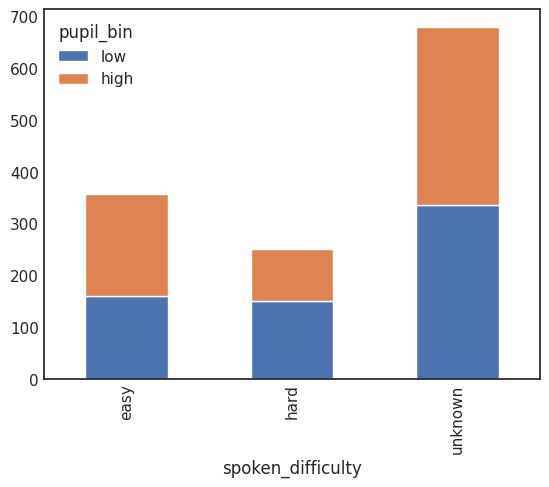

In [145]:
trial_dfs_stacked = trial_dfs.copy()
trial_dfs_stacked.spoken_difficulty = trial_dfs_stacked.spoken_difficulty.fillna('unknown')
trial_dfs_stacked = trial_dfs_stacked.groupby(['spoken_difficulty', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='spoken_difficulty', values=0)
trial_dfs_stacked.plot(kind='bar', stacked=True)
